# **DATA INGESTION**

1.   รวม ml training
2.   + visualize



เตรียมข้อมูล

In [14]:
import os
import shutil
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr
from pyspark.sql.functions import (
    col, when, unix_timestamp, hour, split, regexp_replace,
    trim, year, lower, lit,size
)
from pyspark.sql.types import TimestampType, FloatType


spark = SparkSession.builder.appName("TraffyUltraLite").config("spark.driver.memory", "8g").getOrCreate()

topic_keywords = [
    "ถนน", "ทางเท้า", "แสงสว่าง", "ความสะอาด", "ขยะ", "น้ำท่วม",
    "ระบายน้ำ", "จราจร", "สายไฟ", "ต้นไม้", "ความปลอดภัย",
    "สัตว์", "เสียง", "กลิ่น", "สะพาน", "คลอง"
]

file_path = "/content/bangkok_traffy_with_pm25.csv"
df = spark.read.csv(file_path, header=True, inferSchema=False)

df = df.sample(withReplacement=False, fraction=1.0, seed=42)

df = df.withColumn("timestamp", expr("try_cast(timestamp as timestamp)"))
df = df.filter((year(col("timestamp")) >= 2021) & (year(col("timestamp")) <= 2023))

cols_to_drop = ['photo', 'photo_after', 'address', 'Date', 'province',
                'district_clean', 'star', 'count_reopen', 'ticket_id',
                'state', 'last_activity', 'subdistrict']
df = df.drop(*cols_to_drop)
df = df.withColumn("coords_split", split(col("coords"), ","))


df = df.withColumn("latitude",
                   when(size(col("coords_split")) >= 1, col("coords_split")[0])
                   .otherwise(lit(None)))

df = df.withColumn("longitude",
                   when(size(col("coords_split")) >= 2, col("coords_split")[1])
                   .otherwise(lit(None)))


df = df.withColumn("latitude", expr("try_cast(latitude as float)"))
df = df.withColumn("longitude", expr("try_cast(longitude as float)"))

df = df.drop("coords_split")
df = df.na.drop(subset=["latitude", "longitude", "district"])

df = df.withColumn("type_cleaned", regexp_replace(col("type"), r"[{}]", ""))
df = df.withColumn("district", trim(regexp_replace(col("district"), "เขต", "")))
df = df.withColumn("comment_clean", lower(trim(regexp_replace(col("comment"), r"[^\w\s]", ""))))

flag_cols_list = []
for word in topic_keywords:
    col_name = f"flag_{word}"
    df = df.withColumn(
        col_name,
        when(col("type_cleaned").contains(word) | col("comment_clean").contains(word), 1.0).otherwise(0.0)
    )
    flag_cols_list.append(col_name)

df = df.withColumn("report_hour", hour(col("timestamp")))

df = df.drop("comment", "comment_clean", "type", "type_cleaned", "coords")

save_path = "/content/traffy_district_checkpoint.parquet"
if os.path.exists(save_path):
    shutil.rmtree(save_path)

df.write.parquet(save_path)

In [15]:
df.count()

344033

In [16]:
import os

if os.path.exists("/content/traffy_district_checkpoint.parquet"):

    df_lite = spark.read.parquet("/content/traffy_district_checkpoint.parquet")
    df_lite.show(5)
else:
   pass

+--------------------+----------+--------------------+----------+------------------+---------+---------+--------+------------+-------------+--------------+--------+------------+-------------+----------+----------+-----------+----------------+----------+----------+----------+----------+---------+-----------+
|        organization|  district|           timestamp|pm25_value|     pm25_citywide| latitude|longitude|flag_ถนน|flag_ทางเท้า|flag_แสงสว่าง|flag_ความสะอาด|flag_ขยะ|flag_น้ำท่วม|flag_ระบายน้ำ|flag_จราจร|flag_สายไฟ|flag_ต้นไม้|flag_ความปลอดภัย|flag_สัตว์|flag_เสียง|flag_กลิ่น|flag_สะพาน|flag_คลอง|report_hour|
+--------------------+----------+--------------------+----------+------------------+---------+---------+--------+------------+-------------+--------------+--------+------------+-------------+----------+----------+-----------+----------------+----------+----------+----------+----------+---------+-----------+
|เขตห้วยขวาง,สำนัก...|  ห้วยขวาง|2022-07-25 03:55:...|       9.0|12.82758

ปัจจัยอะไรมีผลต่อการทำให้ time  to solve ช้าลงหรือ เร็วขึ้น เป็น ml model

In [18]:
import os
import shutil
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, when, unix_timestamp, hour, split, regexp_replace,
    trim, year, lower, lit, exp,
    round, collect_set, size, expr, array
)
from pyspark.sql.types import TimestampType, FloatType
from google.colab import drive

from pyspark.ml.regression import AFTSurvivalRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.fpm import FPGrowth

spark = SparkSession.builder.appName("TraffyUltraLite").config("spark.driver.memory", "8g").getOrCreate()


topic_keywords = [
    "ถนน", "ทางเท้า", "แสงสว่าง", "ความสะอาด", "ขยะ", "น้ำท่วม",
    "ระบายน้ำ", "จราจร", "สายไฟ", "ต้นไม้", "ความปลอดภัย",
    "สัตว์", "เสียง", "กลิ่น", "สะพาน", "คลอง"
]

file_path = "/content/bangkok_traffy_with_pm25.csv"

# --- PART 1: DATA PREPARATION (FPGrowth) ---
df = spark.read.csv(file_path, header=True, inferSchema=False)
df = df.sample(withReplacement=False, fraction=1.0, seed=42)

# [FIX 1] ใช้ try_cast จัดการ Timestamp (กันค่า '0' หรือค่าเพี้ยน)
df = df.withColumn("timestamp", expr("try_cast(timestamp as timestamp)"))
df = df.filter((year(col("timestamp")) >= 2021) & (year(col("timestamp")) <= 2023))

cols_to_drop = ['photo', 'photo_after', 'address', 'Date', 'province',
                'district_clean', 'star', 'count_reopen', 'ticket_id',
                'state', 'last_activity', 'subdistrict']
df = df.drop(*cols_to_drop)

# [FIX 2] จัดการ Latitude/Longitude แบบปลอดภัย (กัน IndexOutOfBounds และ Text ปน)
df = df.withColumn("coords_split", split(col("coords"), ","))
df = df.withColumn("latitude",
                   when(size(col("coords_split")) >= 1, col("coords_split")[0])
                   .otherwise(lit(None)))
df = df.withColumn("longitude",
                   when(size(col("coords_split")) >= 2, col("coords_split")[1])
                   .otherwise(lit(None)))

df = df.withColumn("latitude", expr("try_cast(latitude as float)"))
df = df.withColumn("longitude", expr("try_cast(longitude as float)"))

# ลบคอลัมน์ชั่วคราวและแถวที่พิกัดใช้การไม่ได้
df = df.drop("coords_split")
df = df.na.drop(subset=["latitude", "longitude", "district"])

df = df.withColumn("type_cleaned", regexp_replace(col("type"), r"[{}]", ""))
df = df.withColumn("district", trim(regexp_replace(col("district"), "เขต", "")))
df = df.withColumn("comment_clean", lower(trim(regexp_replace(col("comment"), r"[^\w\s]", ""))))

flag_cols_list = []
for word in topic_keywords:
    col_name = f"flag_{word}"
    df = df.withColumn(
        col_name,
        when(col("type_cleaned").contains(word) | col("comment_clean").contains(word), 1.0).otherwise(0.0)
    )
    flag_cols_list.append(col_name)

df = df.withColumn("report_hour", hour(col("timestamp")))
df = df.drop("comment", "comment_clean", "type", "type_cleaned", "coords")

save_path = "/content/traffy_district_checkpoint.parquet"
if os.path.exists(save_path):
    shutil.rmtree(save_path)

df.write.parquet(save_path)

# --- Market Basket Analysis ---
df_basket = df.withColumn("lat_grid", round(col("latitude"), 3)) \
                    .withColumn("long_grid", round(col("longitude"), 3))

flag_cols = [c for c in df.columns if c.startswith('flag_')]
item_expressions = [
    when(col(c) == 1, c.replace("flag_", "")).otherwise(lit(None))
    for c in flag_cols
]

df_items = df_basket.withColumn("items_raw", array(*item_expressions))
df_items = df_items.withColumn("items", expr("filter(items_raw, x -> x is not null)"))

df_ready_fp = df_items.filter(size(col("items")) > 0).select("items")

fp = FPGrowth(itemsCol="items", minSupport=0.001, minConfidence=0.1)
model_fp = fp.fit(df_ready_fp)

print("--- Association Rules ---")
model_fp.associationRules.sort("confidence", ascending=False).show(10, truncate=False)
df_ready_fp.filter(size(col("items")) > 1).show(5, truncate=False)



df_surv = spark.read.csv(file_path, header=True, inferSchema=False)
df_surv = df_surv.sample(withReplacement=False, fraction=1.0, seed=42)


df_surv = df_surv.withColumn("timestamp", expr("try_cast(timestamp as timestamp)"))
df_surv = df_surv.withColumn("last_activity", expr("try_cast(last_activity as timestamp)"))

df_surv = df_surv.filter((year(col("timestamp")) >= 2021) & (year(col("timestamp")) <= 2023))

df_surv = df_surv.withColumn("last_activity", when(col("last_activity").isNull(), col("timestamp")).otherwise(col("last_activity")))
df_surv = df_surv.withColumn("time_to_resolve_hr", (unix_timestamp(col("last_activity")) - unix_timestamp(col("timestamp"))) / 3600.0)

df_surv = df_surv.withColumn("type_cleaned", regexp_replace(col("type"), r"[{}]", ""))
df_surv = df_surv.withColumn("comment_clean", lower(trim(regexp_replace(col("comment"), r"[^\w\s]", ""))))
df_surv = df_surv.withColumn("district", trim(regexp_replace(col("district"), "เขต", "")))
df_surv = df_surv.withColumn("report_hour", hour(col("timestamp")))

topic_keywords_surv = ["ถนน", "ทางเท้า", "แสงสว่าง", "ความสะอาด", "น้ำท่วม", "จราจร", "สายไฟ"]
feature_cols = ["report_hour"]

for word in topic_keywords_surv:
    col_name = f"flag_{word}"
    df_surv = df_surv.withColumn(col_name, when(col("type_cleaned").contains(word) | col("comment_clean").contains(word), 1.0).otherwise(0.0))
    feature_cols.append(col_name)

df_ready_surv = df_surv.withColumn("censor", lit(1.0))
df_ready_surv = df_ready_surv.filter(col("time_to_resolve_hr") > 0.1)
df_ready_surv = df_ready_surv.na.fill(0, subset=feature_cols)

stages_aft = []

indexer = StringIndexer(inputCol="district", outputCol="district_idx", handleInvalid="skip")
encoder = OneHotEncoder(inputCols=["district_idx"], outputCols=["district_vec"])
stages_aft += [indexer, encoder]

assembler = VectorAssembler(inputCols=["district_vec"] + feature_cols, outputCol="features")
stages_aft += [assembler]

aft = AFTSurvivalRegression(featuresCol="features",
                            labelCol="time_to_resolve_hr",
                            censorCol="censor",
                            quantileProbabilities=[0.5],
                            quantilesCol="predicted_quantiles")
stages_aft += [aft]

pipeline_aft = Pipeline(stages=stages_aft)

train_data, test_data = df_ready_surv.randomSplit([0.8, 0.2], seed=42)

model_aft = pipeline_aft.fit(train_data)
predictions = model_aft.transform(test_data)

print("--- Survival Regression Predictions ---")
predictions.select("district", "time_to_resolve_hr", "predicted_quantiles").show(5)

aft_model = model_aft.stages[-1]
coeffs = aft_model.coefficients
print("Coefficients:", coeffs)

--- Association Rules ---
+-----------------------+-------------+-------------------+------------------+---------------------+
|antecedent             |consequent   |confidence         |lift              |support              |
+-----------------------+-------------+-------------------+------------------+---------------------+
|[น้ำท่วม, ความปลอดภัย] |[ถนน]        |0.517910447761194  |1.7947281592850137|0.0014060138494390126|
|[จราจร, ความปลอดภัย]   |[ถนน]        |0.4273015873015873 |1.4807389859625921|0.002726937523551745 |
|[จราจร, ทางเท้า]       |[ถนน]        |0.3906856403622251 |1.353852819956417 |0.0012236777594541262|
|[สะพาน, จราจร]         |[ถนน]        |0.3490566037735849 |1.2095946677362703|0.001349287065888159 |
|[ความปลอดภัย]          |[ถนน]        |0.3110388712131692 |1.0778508586022904|0.03644290651831262  |
|[ความปลอดภัย, แสงสว่าง]|[ถนน]        |0.30376106194690267|1.0526308822829546|0.005563276701094422 |
|[จราจร]                |[ถนน]        |0.2876526458616011 |0.9968

แาดงผลปัจจัยที่มีผลกับเวลาการทำงาน

คาดเดาจำนวนปัญหาที่จะแจ้งมาในอนาคต (7วัน) เป็น  ai model

In [19]:
from pyspark.sql.functions import to_date, dayofweek, dayofmonth, month, lag
from pyspark.sql.window import Window
from pyspark.ml.regression import AFTSurvivalRegression, RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd

In [20]:
รวมเขต

NameError: name 'รวมเขต' is not defined

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3591 (\N{THAI CHARACTER NGO NGU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3592 (\N{THAI CHARACTER CHO CHAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **

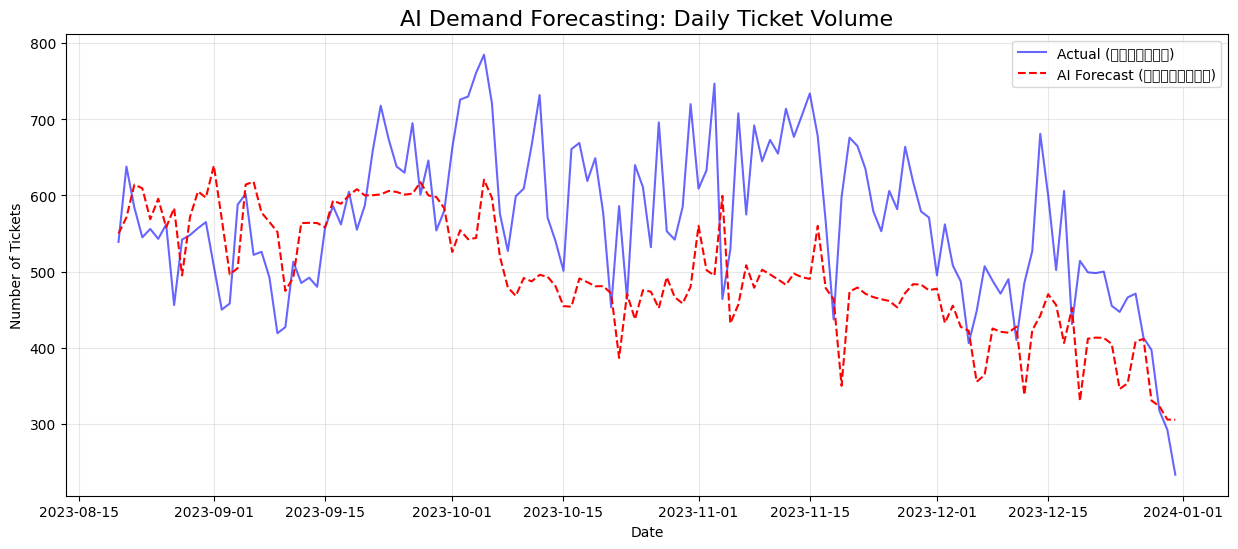

,date,Expected Tickets
127,2023-12-25,353.259839
128,2023-12-26,408.140146
129,2023-12-27,411.502343
130,2023-12-28,330.490809
131,2023-12-29,322.934273
132,2023-12-30,305.492109
133,2023-12-31,305.312493


In [21]:
  df_daily = df.withColumn("date", to_date(col("timestamp"))) \
              .groupBy("date") \
              .count().withColumnRenamed("count", "tickets") \
              .orderBy("date")

  df_features = df_daily.withColumn("day_of_week", dayofweek(col("date"))) \
                        .withColumn("day_of_month", dayofmonth(col("date"))) \
                        .withColumn("month", month(col("date")))

  w = Window.orderBy("date")
  df_features = df_features.withColumn("prev_day_tickets", lag("tickets", 1).over(w))
  df_features = df_features.na.drop()

  assembler = VectorAssembler(
      inputCols=["day_of_week", "day_of_month", "month", "prev_day_tickets"],
      outputCol="features"
  )

  train_count = int(df_features.count() * 0.8)
  df_model_ready = assembler.transform(df_features).select("date", "features", "tickets")
  df_train = df_model_ready.limit(train_count)
  df_test = df_model_ready.subtract(df_train).orderBy("date")

  rf_forecast = RandomForestRegressor(featuresCol="features", labelCol="tickets",
                                      numTrees=100, seed=42)
  model_forecast = rf_forecast.fit(df_train)

  predictions_forecast = model_forecast.transform(df_test)

  rmse = RegressionEvaluator(labelCol="tickets", predictionCol="prediction", metricName="rmse").evaluate(predictions_forecast)

  pdf_pred = predictions_forecast.select("date", "tickets", "prediction").toPandas()

  plt.figure(figsize=(15, 6))
  plt.plot(pdf_pred['date'], pdf_pred['tickets'], label='Actual (ของจริง)', color='blue', alpha=0.6)
  plt.plot(pdf_pred['date'], pdf_pred['prediction'], label='AI Forecast (ที่ทำนาย)', color='red', linestyle='--')

  plt.title('AI Demand Forecasting: Daily Ticket Volume', fontsize=16)
  plt.xlabel('Date')
  plt.ylabel('Number of Tickets')
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.show()

  pdf_pred.tail(7)[['date', 'prediction']].rename(columns={'prediction': 'Expected Tickets'})

ทำนายเหมือนกันแต่คราวนี้แยกตามเขต

รายเขต

In [23]:
from pyspark.sql.window import Window
from pyspark.sql.functions import to_date, dayofweek, dayofmonth, month, lag, col, expr, sum, round
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator


df_district_daily = df.withColumn("date", to_date(col("timestamp"))) \
                         .groupBy("date", "district") \
                         .count().withColumnRenamed("count", "tickets")

w = Window.partitionBy("district").orderBy("date")

df_features = df_district_daily.withColumn("day_of_week", dayofweek(col("date"))) \
                               .withColumn("day_of_month", dayofmonth(col("date"))) \
                               .withColumn("month", month(col("date"))) \
                               .withColumn("prev_day_tickets", lag("tickets", 1).over(w))

df_features = df_features.na.drop()

indexer = StringIndexer(inputCol="district", outputCol="district_idx", handleInvalid="skip")

assembler = VectorAssembler(
    inputCols=["district_idx", "day_of_week", "day_of_month", "month", "prev_day_tickets"],
    outputCol="features"
)

rf = RandomForestRegressor(featuresCol="features", labelCol="tickets", numTrees=40, maxBins=128 ,seed=42)

pipeline_forecast = Pipeline(stages=[indexer, assembler, rf])

train_df, test_df = df_features.randomSplit([0.8, 0.2], seed=42)

model_forecast_district = pipeline_forecast.fit(train_df)
predictions_district = model_forecast_district.transform(test_df)

rmse = RegressionEvaluator(labelCol="tickets", predictionCol="prediction", metricName="rmse").evaluate(predictions_district)

print(f" Accuracy (RMSE): +/- {rmse:.2f} Tickets per District")

predictions_district_summary = predictions_district.groupBy("district") \
    .agg(expr("round(sum(prediction))").alias("total_predicted_tickets")) \
    .orderBy(col("total_predicted_tickets").desc())

predictions_district_summary.show(5, truncate=False)

 Accuracy (RMSE): +/- 8.25 Tickets per District
+--------+-----------------------+
|district|total_predicted_tickets|
+--------+-----------------------+
|จตุจักร |3462.0                 |
|ประเวศ  |2526.0                 |
|บางกะปิ |2480.0                 |
|บางแค   |2390.0                 |
|คลองเตย |2239.0                 |
+--------+-----------------------+
only showing top 5 rows


แสดงผล เฉพาะเขตที่เราสนใจ

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3611 (\N{THAI CHARACTER PO PLA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3607 (\N{THAI CHARACTER THO THAHAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3640 (\N{THAI CHARACTER SARA U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3617 (\N{THAI CHARACTER MO MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **

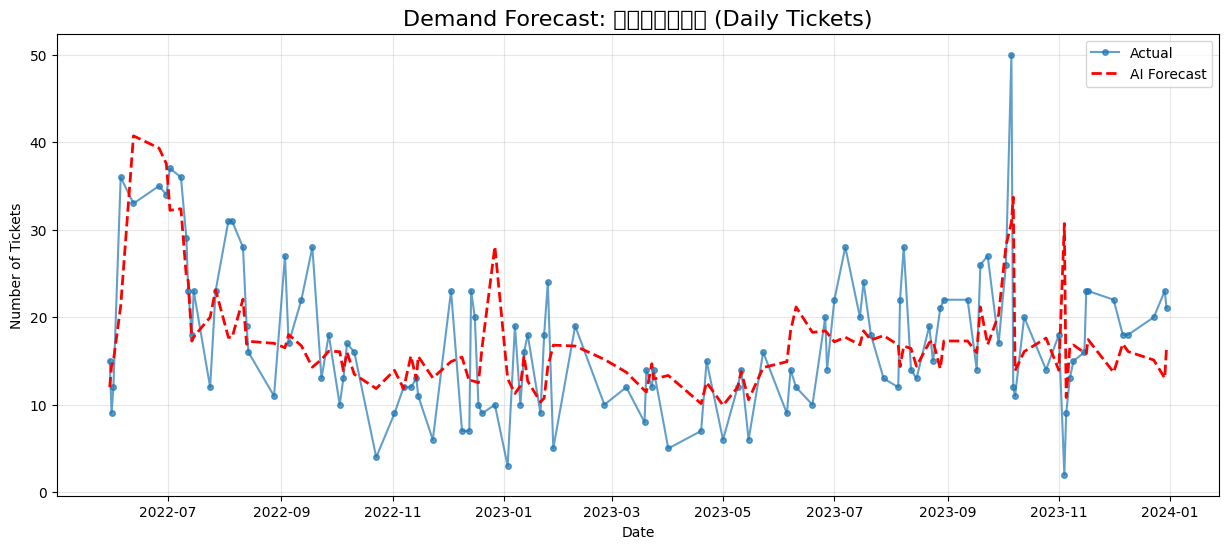

In [25]:
TARGET_DISTRICT = "ปทุมวัน"


pdf_pred_district = predictions_district.filter(col("district") == TARGET_DISTRICT).orderBy("date").toPandas()

if len(pdf_pred_district) > 0:
    plt.figure(figsize=(15, 6))


    plt.plot(pdf_pred_district['date'], pdf_pred_district['tickets'], label='Actual', marker='o', markersize=4, alpha=0.7)
    plt.plot(pdf_pred_district['date'], pdf_pred_district['prediction'], label='AI Forecast', linestyle='--', color='red', linewidth=2)

    plt.title(f'Demand Forecast: {TARGET_DISTRICT} (Daily Tickets)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Number of Tickets')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


    pdf_pred_district[['date', 'tickets', 'prediction']].tail(5)

เป็นการใช้ ml เพื่อหาปัญหาที่มักจะเกิดมาด้วยกัน เช่นนถ้าน้ำท่วมก็เตรียมส่งรถเก็บขยะไปได้เลยเพราะ จะมาพร้อมกัน

In [ ]:
# ... [Your existing Random Forest Code] ...

print("💾 Exporting Forecast Data for Streamlit...")

# 1. Export Global Forecast (City-wide)
# We convert to Pandas and sort by date to ensure the graph looks right
pdf_global = predictions_forecast.select("date", "tickets", "prediction").orderBy("date").toPandas()
pdf_global.to_csv("forecast_global.csv", index=False)

# 2. Export District Forecast
# We need all districts to create the dropdown menu in Streamlit
pdf_district = predictions_district.select("date", "district", "tickets", "prediction").orderBy("date").toPandas()
pdf_district.to_csv("forecast_district.csv", index=False)

print("✅ Files saved: 'forecast_global.csv' and 'forecast_district.csv'")
print("👉 Download these 2 files and put them in your Streamlit folder.")

💾 Exporting Forecast Data for Streamlit...


แสดง insight  ตามพร้อมของอาจารย์

In [ ]:
import os
import shutil
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, when, unix_timestamp, hour, split, regexp_replace,
    trim, year, lower, lit, exp,
    round, collect_set, size, expr, array,
    to_date, dayofweek, dayofmonth, month, lag, sum
)
from pyspark.sql.types import TimestampType, FloatType
from google.colab import drive
from pyspark.sql.window import Window

from pyspark.ml.regression import AFTSurvivalRegression, RandomForestRegressor
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.fpm import FPGrowth

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # เพิ่ม seaborn
import numpy as np # เพิ่ม numpy


In [ ]:
import pyspark.sql.functions as F

In [ ]:
issue_flags = [c for c in df.columns if c.startswith('flag_')]
# 2. แก้ไขการใช้งาน: ใช้ F.sum แทน pyspark_sum
sum_exprs = [F.sum(F.col(f)).alias(f.replace("flag_", "")) for f in issue_flags]
df_problems_spark = df.agg(*sum_exprs)
df_problems_pd = df_problems_spark.toPandas().T.reset_index()
df_problems_pd.columns = ['Problem', 'Count']
df_problems = df_problems_pd.sort_values(by='Count', ascending=False).head(6)


# Data 2: ช่วงเวลาแจ้งเหตุ (Line Chart)
df_time_spark = df.groupBy("report_hour").count().withColumnRenamed("count", "Tickets")
df_time = df_time_spark.orderBy("report_hour").toPandas().rename(columns={'report_hour': 'Hour'})


# Data 3: ปัจจัยที่มีผลต่อเวลาซ่อม (Survival Analysis Result)
# feature_cols = ["report_hour", "flag_ถนน", "flag_ทางเท้า", ...]
# Coeffs index: [0]...[N_dist-2] = District OHE, [N_dist-1] = report_hour, [N_dist] = flag_ถนน, ...
num_districts = len(model_aft.stages[0].labels)
# Select only the flag features (excluding report_hour which is the first in feature_cols)
factor_names = [f.replace('flag_', '') for f in feature_cols if f.startswith('flag_')]

# CORRECTION: The flag coefficients start at index num_districts.
# This ensures flag_coeffs has the same length (7) as factor_names.
flag_coeffs = coeffs[num_districts:]

df_factors = pd.DataFrame({
    'Factor': factor_names,
    # exp(coeff) is the factor by which resolution time is multiplied (Time_Multiplier)
    'Time_Multiplier': np.exp(flag_coeffs)
})

df_factors['Effect'] = df_factors['Time_Multiplier'].apply(lambda x: 'Delays Repair' if x > 1 else 'Speeds Up')

# ------------------------------------------------------------------------------
# 🖼️ DRAW DASHBOARD
# ------------------------------------------------------------------------------
# ตั้งค่า Theme
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(20, 12))
fig.suptitle('Traffy Fondue Analytics Dashboard', fontsize=22, fontweight='bold', y=0.95)

# สร้าง Grid Layout (2 แถว, 3 คอลัมน์)
# แถวบน: สถิติรวม
ax1 = plt.subplot2grid((2, 3), (0, 0)) # Top Left
ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=2) # Top Right (ยาว)

# แถวล่าง: ผลโมเดล
ax3 = plt.subplot2grid((2, 3), (1, 0), colspan=2) # Bottom Left (ยาว - แผนที่)
ax4 = plt.subplot2grid((2, 3), (1, 2)) # Bottom Right

# --- Plot 1: ประเภทปัญหา (Bar) ---
sns.barplot(data=df_problems, x='Count', y='Problem', ax=ax1, palette='viridis')
ax1.set_title('Most Frequent Issues', fontweight='bold')
ax1.set_xlabel('')

# --- Plot 2: ช่วงเวลา (Line) ---
sns.lineplot(data=df_time, x='Hour', y='Tickets', ax=ax2, color='orange', linewidth=2.5, marker='o')
ax2.fill_between(df_time['Hour'], df_time['Tickets'], color='orange', alpha=0.1)
ax2.set_title('Peak Reporting Time (24H)', fontweight='bold')
ax2.set_xticks(range(0, 24, 2))
ax2.set_xlim(0, 23)

# --- Plot 3: Hotspot Map (Scatter) ---
# ใช้ข้อมูลจาก Mock DBSCAN/Hotspot Data Preparation (pdf)
if 'pdf' in locals() and 'cluster' in pdf.columns:
    # กรอง Noise ออก (Mock clusters)
    plot_data = pdf[pdf['cluster'] != -1]
    sns.scatterplot(data=plot_data, x='longitude', y='latitude', hue='cluster',
                    palette='tab20', s=20, ax=ax3, legend=False, alpha=0.7)
    ax3.set_title(f'🗺️ AI Detected Hotspots (Mockup)', fontweight='bold')
    ax3.set_xlabel('Longitude')
    ax3.set_ylabel('Latitude')
    ax3.axis('equal') # รักษาสัดส่วนแผนที่
else:
    ax3.text(0.5, 0.5, 'Run DBSCAN Part to see Map', ha='center', fontsize=14)

# --- Plot 4: AI Factors (Bar) ---
sns.barplot(data=df_factors, x='Time_Multiplier', y='Factor', ax=ax4, hue='Effect', dodge=False, palette={'Delays Repair': '#e74c3c', 'Speeds Up': '#2ecc71'})
ax4.axvline(1.0, color='black', linestyle='--')
ax4.set_title('Impact on Repair Time (AI Model)', fontweight='bold')
ax4.set_xlabel('Time Multiplier (1.0 = Normal)')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()